## Implementing an active learning method with Gaussian Processes 

This notebook illustrates how to use pyrelational to query new data points to fit a Gaussian Process to a non-linear function. The GP model uses a RBF kernel and it is created using gpytorch. The new points are queried using a least confidence strategy. 

In [269]:
import torch
import gpytorch
import pytorch_lightning as pl
import math

from torch.utils.data import Dataset
import matplotlib.pyplot as plt

# Active Learning package
from pyrelational.data import DataManager
from pyrelational.models import LightningModel
from pyrelational.pipeline import Pipeline
from pyrelational.strategies.regression import LeastConfidenceStrategy

## Dataset
In order to simply test our Gaussian Processes, we will create a simple function from which we will sample training, validation and testing points. 

In [270]:
# Simple dataset from non-linear function
def get_dataset():
    pl.seed_everything(0)
    class SimpleDataset(Dataset):
        def __init__(self):
            super(SimpleDataset, self).__init__()
            x = torch.linspace(0, 4 * math.pi, 140)
            y = x * torch.cos(x) + torch.randn(x.size()) * 1e-4 # Function to sample datapoints
            self.x = torch.FloatTensor(x)
            self.y = torch.FloatTensor(y)

        def __len__(self):
            return self.x.shape[0]

        def __getitem__(self, idx):
            return self.x[idx], self.y[idx]

    # Create dataset and splits
    ds = SimpleDataset()
    train_ds, valid_ds, test_ds = torch.utils.data.random_split(ds, [100, 20, 20])
    train_indices = train_ds.indices
    valid_indices = valid_ds.indices
    test_indices = test_ds.indices

    # Create data manager and model
    data_manager = DataManager(
        ds,
        train_indices=train_indices,
        validation_indices=valid_indices,
        test_indices=test_indices,
        loader_batch_size="full",
        loader_shuffle=False,
    )
    return data_manager

We are using [GPytorch](https://gpytorch.ai/) to easily compute GPs implemented in PyTorch. 

In [271]:
# GPytorch model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [277]:
# Pytorch Lightning wrapper for GPytorch
class PyLWrapper(pl.LightningModule):
    def __init__(self, train_x, train_y):
        super(PyLWrapper, self).__init__()
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.gpmodel = ExactGPModel(train_x, train_y, self.likelihood)
        self.criterion = gpytorch.mlls.ExactMarginalLogLikelihood(
            self.likelihood, self.gpmodel
        )

    def forward(self, x):
        return self.gpmodel(x)

    def generic_step(self, batch):
        x, y = batch
        x = self(x)
        loss = -self.criterion(x, y)
        return loss

    def training_step(self, batch, batch_idx):
        return self.generic_step(batch)

    def validation_step(self, batch, batch_idx):
        loss = self.generic_step(batch)
        self.log("loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        loss = self.generic_step(batch)
        self.log("test_loss", loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.gpmodel.parameters(), lr=0.1)


# pyrelational has its own LightningModel class that needs to be modified to work with GPytorch
class GPLightningModel(LightningModel):
    def __init__(self, model_class, model_config, trainer_config):
        super(GPLightningModel, self).__init__(
            model_class, model_config, trainer_config
        )

    def init_model(self, train_loader):
        for train_x, train_y in train_loader:
            return self.model_class(
                train_x=train_x, train_y=train_y, **self.model_config
            )

    def train(self, train_loader, valid_loader):
        trainer, ckpt_callback = self.init_trainer()
        model = self.init_model(train_loader)
        trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=valid_loader)
        if valid_loader is not None:
            model.load_state_dict(
                torch.load(ckpt_callback.best_model_path)["state_dict"]
            )

        self.current_model = model

    def __call__(self, loader):
        with torch.no_grad():
            self.current_model.gpmodel.eval()
            for x, y in loader:
                return self.current_model(x)

We aim to see the evolution of the predictions with the number of labelled data, obtained with a `Least confidence` strategy. 

In [278]:
# the model, datamanager and strategy are all that is needed to create a pipeline
model = GPLightningModel(model_class=PyLWrapper, model_config={}, trainer_config={"epochs": 1})
data_manager = get_dataset()
strategy = LeastConfidenceStrategy()
pipeline = Pipeline(data_manager=data_manager, model=model, strategy=strategy)


INFO:lightning_lite.utilities.seed:Global seed set to 0


We will try the `LeastConfidenceStrategy`, annotating each time 10 more data points, until the full training dataset is used. We will later plot the uncertainty of the prediction obtained with the testset and the unlabelled data.

In [279]:
def active_learning_run(pipeline, num_annotate=10):
    """
    Args:
        pipeline: pyrelational pipeline 
        num_annotate: number of data points to annotate at each iteration
    Return:
        index_dict: the updated indices of the training,
                    unlabelled and query data point after each update
        distributions: the prediction obtained with the GP for 
                    all the (unlabelled + testset) datapoints
    """
    index_dict = {'iteration':[]}
    distributions = []
    test_distribution = [] 

    # run until there is no unlabelled data left
    while len(pipeline.u_indices) > 0:
            print('percentage of labelled data: {:.2f}'.format(pipeline.percentage_labelled))      
            # New data to be annotated based on the active learning strategy
            to_annotate = pipeline.active_learning_step(num_annotate)

            # get the predictions on the unlabelled data 
            unlabelled_ids = pipeline.u_indices
            labelled_ids = pipeline.l_indices
            predictions = pipeline.model(pipeline.u_loader)
            distributions.append(predictions) 

            # get prediction on the test set
            test_predictions = pipeline.model(pipeline.test_loader)
            test_distribution.append(test_predictions)

            # Query new data and update the data manager 
            pipeline.active_learning_update(indices=to_annotate, update_tag="Manual Update")

            # append index dictionnary for plots
            index_dict['iteration'].append(
                {'unlabelled': unlabelled_ids, # unlabelled data
                'labelled': labelled_ids, # labelled data
                'query': to_annotate, # data to be annotated in the next iteration
                'test': test_distribution # test data
                 }) 

    return index_dict, distributions, test_distribution

# run the active learning pipeline
index_dict, distributions, test_distribution = active_learning_run(pipeline, num_annotate=10)

percentage of labelled data: 10.00
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 35.77it/s, loss=12.1, v_num=564]
percentage of labelled data: 20.00
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 37.17it/s, loss=6.93, v_num=565]
percentage of labelled data: 30.00
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 38.72it/s, loss=6.09, v_num=566]
percentage of labelled data: 40.00
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 38.69it/s, loss=4.87, v_num=567] 
percentage of labelled data: 50.00
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 39.14it/s, loss=4.07, v_num=568] 
percentage of labelled data: 60.00
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 33.37it/s, loss=3.83, v_num=569]
percentage of labelled data: 70.00
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 37.58it/s, loss=3.58, v_num=570] 
percentage of labelled data: 80.00
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 36.88it/s, loss=3.25, v_num=571] 
percentage of labelled data: 90.00
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 34.58it/s, loss=2.99,

In [280]:
plt.rcParams['figure.figsize'] = [10, 5]


def plot_gaussian_process(data_manager, distributions, test_distribution, index_dict):
    """
    Args:
        data_manager: data manager used for the model
        distributions: distribution obtained using the GP model for the 
                       all the (unlabelled + testset) data points
        index_dict: return the indices of the training, query and 
                    unlabelled datasets, that are updated with the Oracle
    """

    # true function
    func = lambda x: x * torch.cos(x)
    
    # labelled, unlabelled and queried indices updated with the active learning strategy
    labelled_ids = index_dict['labelled']
    unlabelled_ids = index_dict['unlabelled']
    query_ids = index_dict['query']

    # getting datasets
    dataset = data_manager.dataset
    labelled_x, labelled_y = dataset[labelled_ids]
    unlabelled_x, unlabelled_y = dataset[unlabelled_ids]
    test_x, test_y = dataset[data_manager.test_indices]

    # reorder indices for matplotlib
    unlabelled_x, unlabelled_ids = torch.sort(unlabelled_x.detach())

    # # get mean and covariance of prediction
    unlabelled_loc = distributions.loc
    unlabelled_loc = distributions.loc[unlabelled_ids]
    unlabelled_std = distributions.stddev[unlabelled_ids]
    
    # plot figure
    ax = plt.axes()
    axis_x = torch.linspace(0, 4 * math.pi, 100)
    ax.plot(axis_x, func(axis_x), color='lightsteelblue')
    ax.plot(labelled_x, labelled_y, 'o', markersize=4, label='observations', color='royalblue', alpha=0.4)
    ax.plot(unlabelled_x, unlabelled_loc, 'o', markersize=4, label='predictions', color='orange', alpha=0.4)
    if query_ids is not None:
        query_x, query_y = dataset[query_ids]
        ax.plot(query_x, query_y, 'o', markersize=2, label='query', color='red')
    err = 1.96 * unlabelled_std
    ax.fill_between(unlabelled_x, unlabelled_loc - err, unlabelled_loc + err, color='papayawhip', alpha=0.8)
    ax.legend(loc='upper right')
    plt.show()

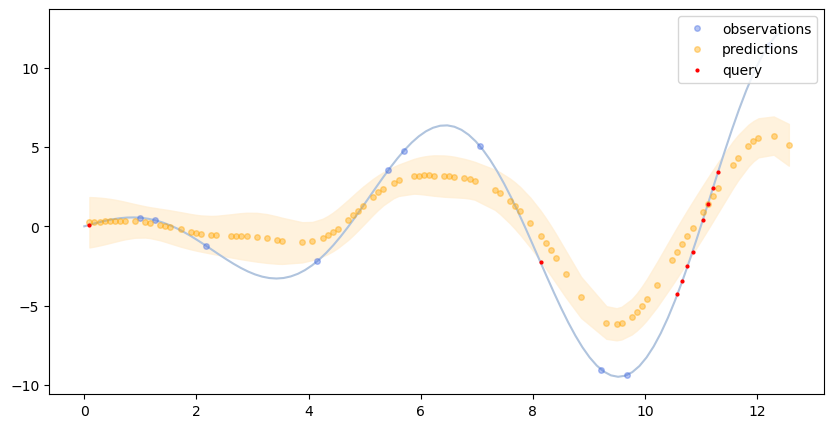

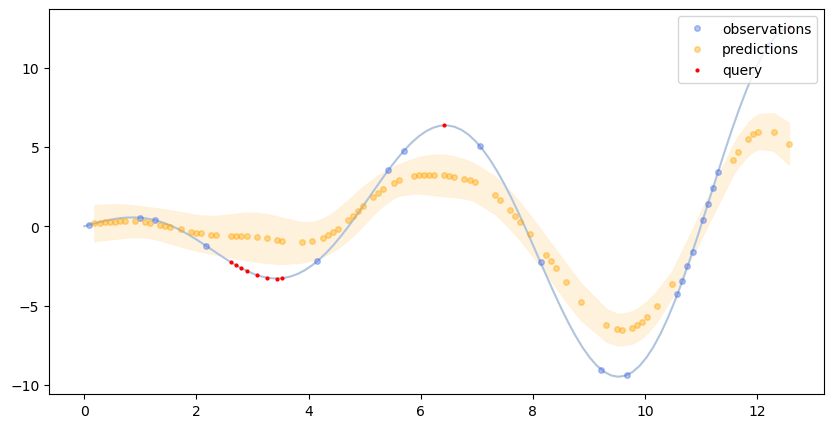

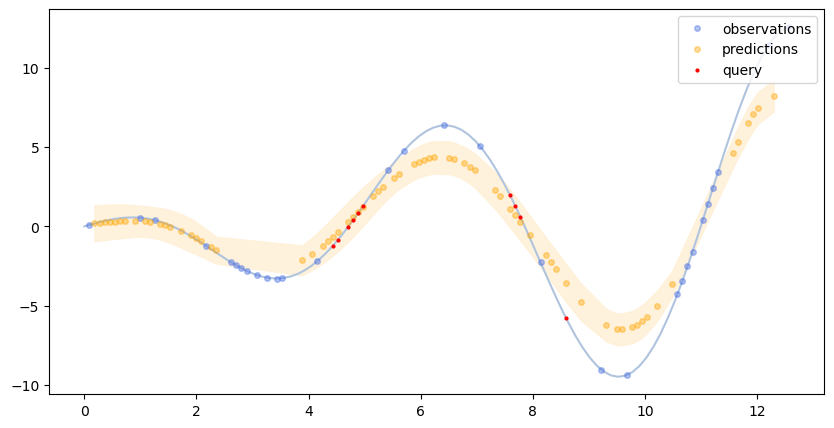

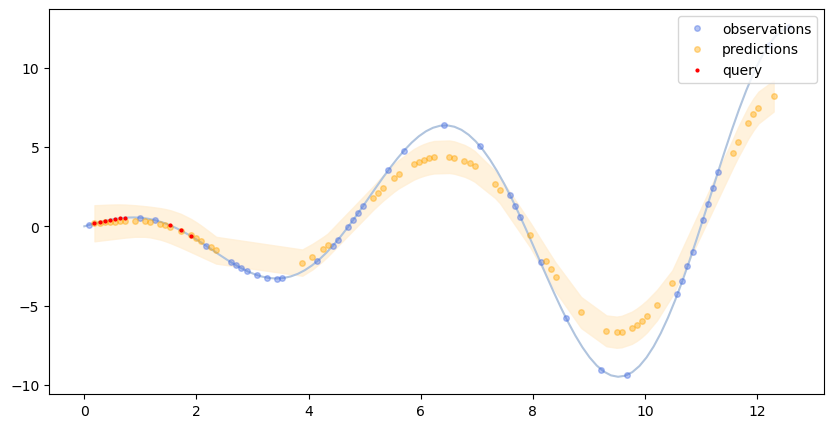

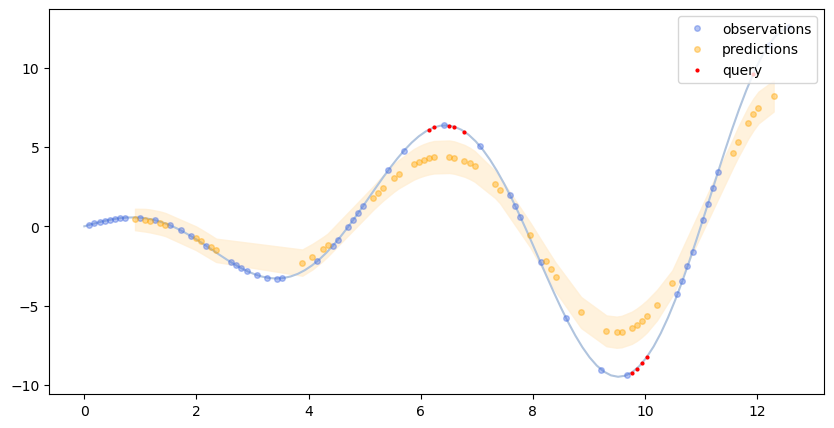

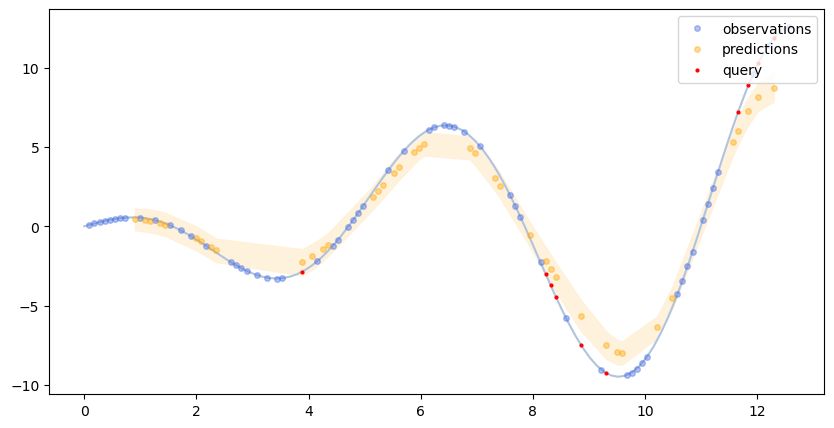

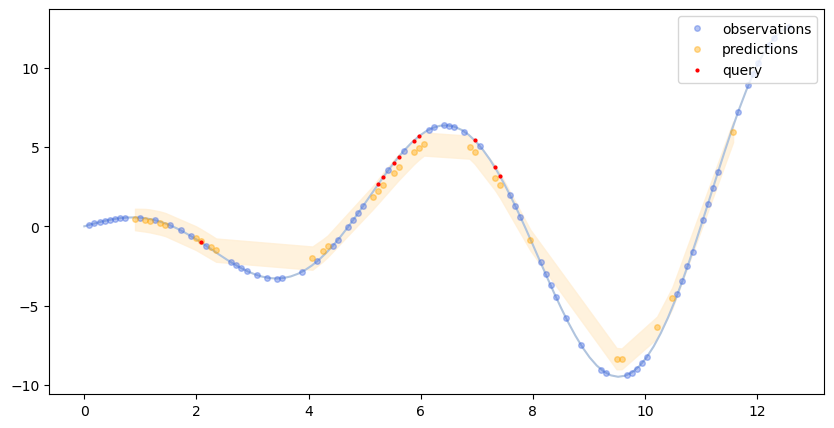

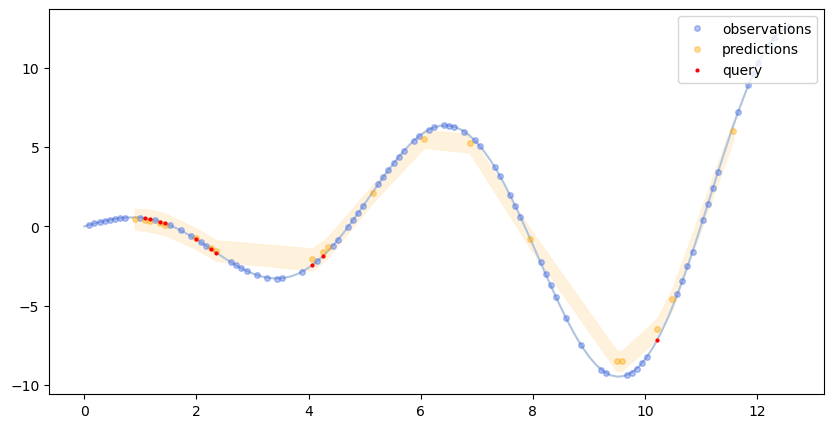

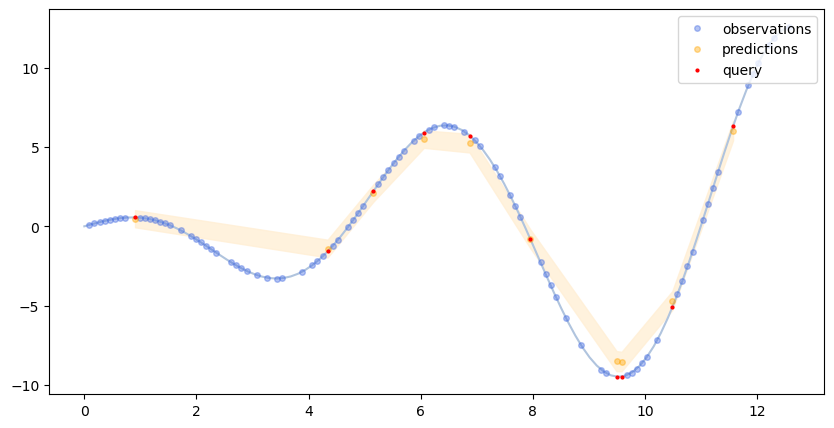

In [281]:
for i in range(len(index_dict['iteration'])):
    plot_gaussian_process(data_manager, distributions[i], test_distribution[i], index_dict['iteration'][i])